## Purpose of this notebook

In our typical workflow, we move over to a computing cluster to generate conformers for all compounds. We will need 3D conformers for each compound in order to obtain 3D shape + color Tanimoto combo scores.

The following notebook provides a small-scale example of what we do in the conformer generation process, and provides a simple demonstration of our underlying workflow. We also provide the code necessary to run the conformer generation process on a computing cluster.

Input:
- `sample_compounds.csv`: list of SMILES for the compounds to generate conformers for 

Output:
- `sample_compounds.oeb`: OpenEye binary file with coordinates of generated conformers for each compound
- `sample_compounds.log`: file of warning messages later used to parse compounds with unspecified stereochemistry
- `sample_compounds.pkl`: dictionary containing the indices of compounds and their specified enumerated stereoisomers

In [1]:
from openeye import oechem, oeomega
import numpy as np
import pandas as pd
import pickle
from IPython.display import display

# Load in file containing helpful pre-made functions
import tools

### Import data

In [3]:
data = pd.read_csv('../files/sample_compounds.csv')
display(data)
## Set up error catching
## This file will save the error message returned for all compound that do not have specified stereochemistry
filename = '../files/sample_compounds'
logfile = filename + '.log'
errfs = oechem.oeofstream(logfile)
oechem.OEThrow.SetOutputStream(errfs)

,SMILES
0,C(C#N)[C@H](C(=O)O)N
1,C(C(=O)O)N
2,C(C(C(=O)O)N)C(=O)N
3,C(CC(=O)N)[C@@H](C(=O)O)N
4,C(CC(=O)O)CN


### Generate conformers

We start with 5 compounds and end with 6. The reason for this is because compound 2 has unspecified stereochemistry and is split into two potential stereoisomers. We can visualize this below.

In [4]:
# initialize structures to store information
new_table = pd.DataFrame(columns=['index', 'Molecule'])
indices = []
molecules = []
smiles = []
smiles_2 = []

# generate conformers for all SMILES strings
for index, smi in enumerate(data['SMILES']):
    mol = tools.smiles_to_oemol(smi)
    oechem.OETriposAtomNames(mol)
    mol = tools.normalize_molecule(mol)
    cmol = None
    # try to generate conformers for the given molecule
    try:
        cmol = tools.generate_conformers(mol, max_confs=200)
        smiles.append(smi)
        smiles_2.append(smi)
        indices.append(index)
        molecules.append(cmol)

    # will fail if molecule does not have specified stereochemistry
    except Exception as e:
        # write warning message into `warnfile`, which is later parsed to extract molecule indices
        oechem.OEThrow.Warning('Molecule {} returned an error\n{}'.format(index, str(e)))

    # enumerates all possible stereoisomers for a compound with unspecified stereochemistry
    if cmol is None:
        for nmol in oeomega.OEFlipper(mol):
            oechem.OETriposAtomNames(nmol)
            # generate conformers for all valid stereoisomers
            try:
                nmol = tools.generate_conformers(nmol, max_confs=200)
                smiles.append(smi)
                smiles_2.append(oechem.OECreateIsoSmiString(nmol))
                #nmol.SetTitle(oechem.OECreateIsoSmiString(nmol))
                indices.append(index)
                molecules.append(nmol)
            except Exception:
                pass

new_table['index'] = indices
new_table['Molecule'] = molecules
new_table['num_confs'] = new_table['Molecule'].apply(lambda x: x.NumConfs())
new_table['SMILES'] = smiles
new_table['enumerated_SMILES'] = smiles_2
# view the number of conformers generated for each compound 
# and compare original SMILES to SMILES of enumerated stereoisomers
# new_table['num_confs'] = new_table['Molecule'].apply(lambda x: x.NumConfs())
# new_table['enumerated_SMILES'] = new_table['Molecule'].apply(lambda x: x.GetTitle())
# new_table = pd.merge(new_table, data, how='right', left_on='index', right_index=True)
display(new_table)

,index,Molecule,num_confs,SMILES,enumerated_SMILES
0,0,<oechem.OEMol; proxy of <Swig Object of type '...,8,C(C#N)[C@H](C(=O)O)N,C(C#N)[C@H](C(=O)O)N
1,1,<oechem.OEMol; proxy of <Swig Object of type '...,2,C(C(=O)O)N,C(C(=O)O)N
2,2,<oechem.OEMol; proxy of <Swig Object of type '...,26,C(C(C(=O)O)N)C(=O)N,C([C@@H](C(=O)O)N)C(=O)N
3,2,<oechem.OEMol; proxy of <Swig Object of type '...,27,C(C(C(=O)O)N)C(=O)N,C([C@H](C(=O)O)N)C(=O)N
4,3,<oechem.OEMol; proxy of <Swig Object of type '...,42,C(CC(=O)N)[C@@H](C(=O)O)N,C(CC(=O)N)[C@@H](C(=O)O)N
5,4,<oechem.OEMol; proxy of <Swig Object of type '...,14,C(CC(=O)O)CN,C(CC(=O)O)CN


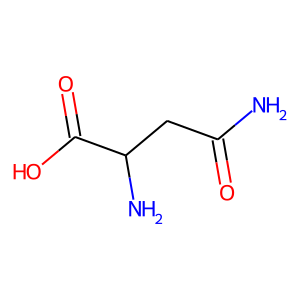

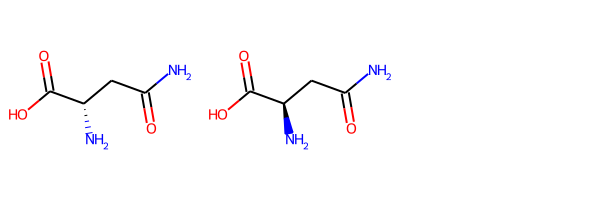

In [5]:
import rdkit 
from rdkit import Chem
from rdkit.Chem import Draw

# visualize original compound and its stereoisomers
original_mol = Chem.MolFromSmiles(new_table['SMILES'][2])
split_mols = [Chem.MolFromSmiles(smi) for smi in new_table['enumerated_SMILES'][2:4]]
display(Draw.MolToImage(original_mol))
display(Draw.MolsToGridImage(split_mols))

### Read log file

With our OMEGA settings, all compounds with unspecified stereochemistry are flagged. We store these error messages in a `.log` file, which we parse later to get the indices of all compounds with unspecified stereochemistry. 

In [6]:
# view the results of the warn file
f = open(logfile, 'r')
for line in f:
    print(line)



omega returned error code 0



### Create index file

We create a dictionary where the key is the id of the original compound and the value is a list of the ids for all its enumerated stereoisomers. Should there be multiple compounds with unspecified stereochemistry, there will be multiple key-value pairs stored in the dictionary.

In [7]:
## Record the compounds with enumerated stereoisomers and their indices for later analysis
## Create a dictionary where the index of the original compound is the key
## and the index of all valid stereoisomers are the values
groupings = {}
group = []
for index, value in enumerate(indices[:-1], 1):
    # start storing indices if the value of entry is same as the previous
    if indices[index] == indices[index-1]:
        group.append(index-1)
        # edge case to close off group if it occurs at the very end of the list
        if index == len(indices)-1:
            group.append(index)
            groupings[value] = group
    # stop storing indices once value has changed, close off list, append it and make a new list
    elif indices[index] != indices[index-1] and group:
        group.append(index-1)
        groupings[value] = group
        group = []
    else:
        continue

print(groupings)
indfile = filename + '.pkl'
pickle.dump(groupings, open(indfile, 'wb'))

{2: [2, 3]}


### Read error

Quality assurance step: we need to confirm that we successfully generated conformers for all enumerated stereoisomers. This procedure is contained in the function `tools.read_error()` 

In [8]:
# Extract the indices of compounds with unspecified stereochemistry
problem_ind = []
with open(logfile, 'r') as fp:
    for line in fp:
        if line.find('Molecule') != -1:
            val = [int(s) for s in line.split() if s.isdigit()]
            problem_ind.append(val[0])

## Store molecule indices as a set for easier operations
problem_ind = set([int(x) for x in problem_ind])
print(problem_ind)

{2}


In [9]:
## Load in dictionary of {original_compound_id: [stereoisomer_compound_ids]}
grouping = pickle.load(open(indfile, 'rb'))
grouping_ind = set(grouping.keys())
print(grouping_ind)

{2}


In [10]:
## Verify all compounds stored in the logfile now have enumerated stereoisomers
if problem_ind == grouping_ind:
    print('Stereochemistry enumerated for all compounds!')
else:
    print('Check molecules {}'.format(problem_ind ^ grouping_ind))

Stereochemistry enumerated for all compounds!


### Save dataframe as OpenEye binary (.oeb) file
If we find that stereochemistry has been successfully enumerated for all compounds, we save the dataframe as an OpenEye binary (.oeb) file, which we then feed into our 3D Tanimoto combo scoring script.


In [11]:
tools.write_dataframe_to_file(new_table, '../files/sample_compounds.oeb')